# package initial

In [1]:
from google.colab import drive
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import shutil

In [2]:
from tensorflow.keras.models import  Model, load_model
from tensorflow.keras.applications import  InceptionResNetV2
from tensorflow.keras.layers import  Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

In [3]:
if not os.path.exists("mask_images.zip"):
    drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
if not os.path.exists("mask_images.zip"):
    !cp /content/drive/MyDrive/paper/resource1/test_images.zip test_images.zip
    !cp /content/drive/MyDrive/paper/resource1/mask_images.zip mask_images.zip
    !cp /content/drive/MyDrive/paper/resource1/haarcascade_frontalface_default.xml haarcascade_frontalface_default.xml

# data preprocessing

In [7]:
shutil.rmtree('test_images', ignore_errors=True)
shutil.rmtree('mask_images', ignore_errors=True)
ZipFile("test_images.zip").extractall("test_images")
ZipFile("mask_images.zip").extractall("mask_images")

In [8]:
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [9]:
train_dir = 'mask_images/Face Mask Dataset/Train'
valid_dir = 'mask_images/Face Mask Dataset/Validation'

BATCH_SIZE = 32
IMG_SHAPE = 128

In [10]:
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    channel_shift_range=10,                            
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest')
train_generator = train_datagenerator.flow_from_directory(
    train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

valid_datagenerator = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagenerator.flow_from_directory(
    valid_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# model training

In [11]:
def createModel():
  baseModel = InceptionResNetV2(weights="imagenet", include_top=False)
  
  headModel = baseModel.output
  headModel = GlobalAveragePooling2D()(headModel)
  headModel = Dense(1024, activation="relu")(headModel)
  headModel = Dropout(0.2)(headModel)
  predictions = Dense(2, activation="sigmoid")(headModel)
  return Model(inputs=baseModel.input, outputs=predictions)

In [ ]:
clear_session()

epochs = 20

model = createModel()

model.compile(
    optimizer=Adam(learning_rate=0.00002),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
#model.summary()

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//valid_generator.batch_size)

Epoch 1/20
312/312 [==============================] - 96s 208ms/step - loss: 0.3293 - accuracy: 0.8593 - val_loss: 1.6591 - val_accuracy: 0.9937
Epoch 2/20
312/312 [==============================] - 62s 198ms/step - loss: 0.0474 - accuracy: 0.9839 - val_loss: 0.6844 - val_accuracy: 0.9937
Epoch 3/20
312/312 [==============================] - 62s 198ms/step - loss: 0.0214 - accuracy: 0.9925 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/20
312/312 [==============================] - 62s 198ms/step - loss: 0.0141 - accuracy: 0.9959 - val_loss: 0.7261 - val_accuracy: 0.9975
Epoch 5/20
312/312 [==============================] - 62s 197ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 6.1232e-04 - val_accuracy: 1.0000
Epoch 6/20
312/312 [==============================] - 62s 197ms/step - loss: 0.0078 - accuracy: 0.9977 - val_loss: 8.1657e-04 - val_accuracy: 1.0000
Epoch 7/20
312/312 [==============================] - 62s 197ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 3.2620e

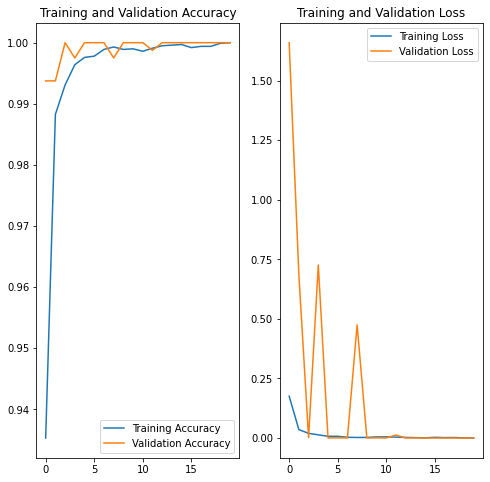

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# prediction

In [15]:
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

mask_label = {0:'MASK',1:'NO MASK'}
mask_color = {0:(0,255,0),1:(255,0,0)}

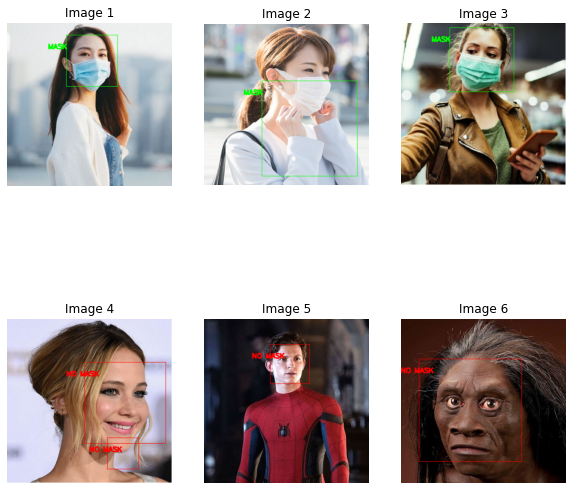

In [16]:
count = 0
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for seq in range(1, 7):
    img = cv2.imread('test_images/' + str(seq) + '.jpeg')
    if img is not None:
        img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)
        for i in range(len(faces)):
            (x,y,w,h) = faces[i]
            crop = new_img[y:y+h,x:x+w]
            crop = cv2.resize(crop,(IMG_SHAPE,IMG_SHAPE))
            crop = np.reshape(crop,[1,IMG_SHAPE,IMG_SHAPE,3])/255.0
            mask_result = model.predict(crop)
            cv2.putText(new_img,mask_label[mask_result.argmax()],(x-40, y+30),cv2.FONT_HERSHEY_SIMPLEX,0.5,mask_color[mask_result.argmax()],2)
            cv2.rectangle(new_img,(x,y),(x+w,y+h),mask_color[mask_result.argmax()],1)
        ax = list(axes.flatten())[count]
        ax.imshow(new_img)
        ax.set_title('Image ' + str(count+1))
        ax.axis('off')
        count += 1
plt.show()